### Retrieval Scoring + ranking


In [1]:
## Init stuff
import os
import json
import psycopg2
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()  # reads .env if present

REDDIT_CLIENT_ID = os.getenv("REDDIT_CLIENT_ID")
REDDIT_CLIENT_SECRET = os.getenv("REDDIT_CLIENT_SECRET")
REDDIT_USER_AGENT = os.getenv("REDDIT_USER_AGENT") or "knowledge-collection-service/0.1"

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# --- connect to Postgres ---
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    dbname="knowledgebase",
    user="stiw_user",
    password="stiw_pwd"
)
cursor = conn.cursor()
print("✅ Connected to Postgres and OpenAI")

✅ Connected to Postgres and OpenAI


Run once for Query & Query Embed, & test other systems for tweaks


In [2]:
user_input = input("Enter your query or goal: ").strip()
print(f"Query: --> {user_input}")

# Running HyDE style query improvement 

HyDE_prompt = f"""
You are an extremely empathetic Reddit user writing a raw, honest submission asking for help.
Write a detailed (150–250 word) Reddit post (title + body) from someone in exactly the same situation as the user below.
Make it the kind of thoughtful, non-ranty, "I know I need to change, please help me" post that gets tons of supportive, practical, life-changing advice in the comments.

Query / situation: {user_input}

Start directly with the post (include a realistic title and then the body). 
Do NOT write advice or a success story — only the help-seeking post.
"""

print("Creating a HyDE hypothetical Reddit submission (OP post)...")
HyDE_response = client.chat.completions.create(
    model="gpt-4o-mini",       
    messages=[
        {"role": "system", "content": "You are a Reddit user asking for help in a detailed, vulnerable way."},
        {"role": "user", "content": HyDE_prompt}
    ],
    temperature=0.8, # keeps it varied and natural
    max_tokens=500 # Wanna limit token usage here to create precise embeddings
)

HyDE_answer = HyDE_response.choices[0].message.content.strip()

print("\📄 HyDE generated hypothetical Reddit submission \n")
print(HyDE_answer)

# Embedd HyDE, query
q_emb = client.embeddings.create(
        model="text-embedding-3-small",
        input=HyDE_answer
    ).data[0].embedding
print("✅ Query Embedding generated...")

Query: --> I wanna loose weight, and be mentally fit
Creating a HyDE hypothetical Reddit submission (OP post)...
\📄 HyDE generated hypothetical Reddit submission 

**Title: Struggling with Weight and Mental Health - Seeking Guidance on My Journey to Wellness**

Hi everyone,

I’m reaching out here because I feel overwhelmed and lost on my journey to lose weight and improve my mental health. For a long time, I've battled with my self-image and have often turned to food as a comfort during tough times. This has led to a cycle where I feel guilty after eating unhealthy foods, which then affects my mental state even more. I know I need to change, but I'm not sure where to start.

I recently realized that my weight and mental health are interconnected, and it's hard to focus on one without addressing the other. I want to create a healthier lifestyle, but I struggle with motivation and consistency. My past attempts at dieting have often ended in frustration or feelings of failure. 

I’m hopin

In [3]:
print(q_emb)

[0.0424908846616745, -0.024421818554401398, 0.019497886300086975, 0.03917162865400314, -0.031456004828214645, 0.006512118503451347, 0.011106321588158607, 0.039699193090200424, -0.002802683738991618, 0.04906345531344414, -0.001038641668856144, 0.022311560809612274, -0.035214897245168686, -0.01999247819185257, -0.012892345897853374, 0.04145773872733116, 0.031192222610116005, 0.04117197543382645, 0.008963093161582947, 0.05869149789214134, 0.057812225073575974, -0.011650372296571732, 0.01205703616142273, 0.013540809974074364, 0.013244055211544037, -0.03774280846118927, 0.019915541633963585, -0.0015126249054446816, 0.012782436795532703, 0.0012811287306249142, 0.0013669952750205994, 0.002896106569096446, -0.0696384534239769, 0.0002715099835768342, 0.014090355485677719, -0.011067853309214115, -0.03128014877438545, -0.002545771189033985, 0.05706484243273735, 0.010523802600800991, -0.006121940910816193, -0.016255566850304604, 0.08863075822591782, 0.03251113370060921, -0.03508300706744194, 0.007

Running through retrieved chunks for new scoring


In [4]:
print("Retrieveing top matching submissions....")
cursor.execute("""
            SELECT 
                submission_id,
                domain_id,
                title, 
                selftext, 
                permalink, 
                (embedding <=> %s::vector) AS distance
            FROM submissions
            ORDER BY embedding <=> %s::vector
            LIMIT 15;
        """, (json.dumps(q_emb), json.dumps(q_emb)))
top_subs = cursor.fetchall()
top_subs = [subs for subs in top_subs if subs[5] < 0.45]
if not top_subs:
    print("❌ No Relevant submissions found")
else:
    print(f"✅ Found {len(top_subs)} relevant submissions")

# Printing submissions
print(json.dumps(top_subs, indent=5))

Retrieveing top matching submissions....
✅ Found 6 relevant submissions
[
     [
          "9hjn8y",
          "953de4be-d2f0-4ca2-9a89-252ce61ad883",
          "Everything I've Learned About Obesity is Right (and How I Used That To Lose 150lbs)",
          "##How It Started\n\nThe date is June 30th, 2017. My name is Amanda and I weigh 331lbs. I just finished up an appointment at the gynecologist to get a mirena put in. My gynecologist, a sweet asian-american in her early 30s with a healthy body and kind face, tells me that the procedure is finished and I am good to go, but... \n\n\"Your blood pressure is awfully high, I am worried about you,\" she adds quickly. \"It was high last time, too. You should really see a doctor, there is one here, I can give you a recommendation. He's very business-oriented and scientific, you'll like him.\" \n\nHesitantly, I agree. This is not the first time someone has spoken to me about my blood pressure, but it will be the first time I have visited a doc

In [5]:
# Collect related comments
context_blocks = []
sources = []  # track all permalinks for final output

top_submission_ids = [row[0] for row in top_subs]
print(top_submission_ids)


# Pulling in the most Relevant comments from only the top posts that we get
# There is also a small scoring boost for the high upvoted comments, at the time of querying
# Relevance first tho, only then popularity
query = """
WITH ranked_comments AS (
    SELECT 
        c.body,
        c.score,
        s.title,
        c.submission_id,
        s.permalink,
        c.embedding <=> %s::vector AS distance
    FROM comments c
    JOIN submissions s ON c.submission_id = s.submission_id
    WHERE c.submission_id = ANY(%s)
)
SELECT 
    body,
    score,
    title,
    submission_id,
    permalink,
    distance
FROM ranked_comments
ORDER BY 
    distance + (1.0 / (score + 10)) ASC 
LIMIT 20;
"""

# Note the order of parameters is now --> embedding, submission_ids list
cursor.execute(query, (json.dumps(q_emb), top_submission_ids))
relevant_comments = cursor.fetchall()

print(f"\n✅ Retrieved {len(relevant_comments)} relevant comments\n")

# for i, (body, score, title, permalink, distance) in enumerate(relevant_comments, 1):
#     print(f"{i:2d}. ↑{score}  (dist: {distance:.4f}) | {title}")
#     print(f"     {body.strip()[:900]}{'...' if len(body) > 900 else ''}")
#     print(f"     https://reddit.com{permalink}\n")
# print("="*120)

# Context map contains : submission_id -> {submission_info, comments}
context_map = {}

# building submission details
submission_details = {}
for sub in top_subs:
    submission_id = sub[0]
    title = sub[2]
    selftext = sub[3]
    permalink = sub[4]
    
    submission_details[submission_id] = {
        'title': title,
        'selftext': selftext,
        'permalink': permalink
    }


for comment in relevant_comments:
    body = comment[0]
    score = comment[1]
    title = comment[2]
    submission_id = comment[3]
    permalink = comment[4]
    distance = comment[5]
    
    if submission_id not in context_map:
        # Get selftext from submission_details
        sub_info = submission_details.get(submission_id, {})
        
        context_map[submission_id] = {
            'title': title,
            'permalink': permalink,
            'selftext': sub_info.get('selftext', ''),
            'comments': []
        }
    
    context_map[submission_id]['comments'].append({
        'body': body,
        'score': score,
        'distance': distance
    })

print(f"✅ Built context map with {len(context_map)} submissions\n")
print(json.dumps(context_map, indent=5))

['9hjn8y', 'a2dmje', '8hht7o', '93kcov', 'z9q8hm', '995lst']

✅ Retrieved 20 relevant comments

✅ Built context map with 5 submissions

{
     "9hjn8y": {
          "title": "Everything I've Learned About Obesity is Right (and How I Used That To Lose 150lbs)",
          "permalink": "https://www.reddit.com/r/loseit/comments/9hjn8y/everything_ive_learned_about_obesity_is_right_and/",
          "selftext": "##How It Started\n\nThe date is June 30th, 2017. My name is Amanda and I weigh 331lbs. I just finished up an appointment at the gynecologist to get a mirena put in. My gynecologist, a sweet asian-american in her early 30s with a healthy body and kind face, tells me that the procedure is finished and I am good to go, but... \n\n\"Your blood pressure is awfully high, I am worried about you,\" she adds quickly. \"It was high last time, too. You should really see a doctor, there is one here, I can give you a recommendation. He's very business-oriented and scientific, you'll like him.\" \n

# Looking at more fetched comment details


In [6]:
# Prepare for generation, 
context_blocks = []
sources = []

for submission_id, data in context_map.items():
    title = data['title']
    permalink = data['permalink']
    selftext = data['selftext']
    comments = data['comments']
    
    # Format comments
    joined_comments = "\n".join([
        f"- (↑{c['score']}) {c['body'][:600]}..." 
        for c in comments
    ])
    
    # Build block
    block = f"""
[POST] "{title}"
URL: {permalink}

{selftext[:1200] if selftext else "(No text body)"}

Top Comments:
{joined_comments}
"""
    context_blocks.append(block)
    sources.append(f"- {title}: {permalink}")

# Final context text to pass to LLM
context_text = "\n\n---\n\n".join(context_blocks)

print("CONTEXT FOR LLM:")
print(context_text)
print("\n" )
print("SOURCES:")
print("\n".join(sources))

CONTEXT FOR LLM:

[POST] "Everything I've Learned About Obesity is Right (and How I Used That To Lose 150lbs)"
URL: https://www.reddit.com/r/loseit/comments/9hjn8y/everything_ive_learned_about_obesity_is_right_and/

##How It Started

The date is June 30th, 2017. My name is Amanda and I weigh 331lbs. I just finished up an appointment at the gynecologist to get a mirena put in. My gynecologist, a sweet asian-american in her early 30s with a healthy body and kind face, tells me that the procedure is finished and I am good to go, but... 

"Your blood pressure is awfully high, I am worried about you," she adds quickly. "It was high last time, too. You should really see a doctor, there is one here, I can give you a recommendation. He's very business-oriented and scientific, you'll like him." 

Hesitantly, I agree. This is not the first time someone has spoken to me about my blood pressure, but it will be the first time I have visited a doctor in almost 8 years. 

Thyroid issues, blood pressu

### Step Extraction + K-Clustering


In [7]:
all_steps = []
action_step_prompt = """
Extract actionable steps the user could take that are either:
• explicitly stated OR
• strongly implied by the comment

You may rewrite the steps in your own words BUT:
- Do NOT invent new ideas
- Do NOT give generic advice unrelated to the comment
- Keep each step specific and short (max 15 words)

Return ONLY:
{"steps": ["step 1", "step 2", ...]}

COMMENT:
"""

for sub_id, sub_data in context_map.items():
    print(f"\nDeriving Actionable steps for Submission -> {sub_data['title']} [{sub_id}]")

    for c in sub_data['comments']:
        comment_body = c["body"]
        score = c["score"]

        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "Extract only actionable steps, implied or explicit."},
                {"role": "user", "content": action_step_prompt + comment_body}
            ],
            temperature=0.1,
            max_tokens=150
        )

        raw = resp.choices[0].message.content
        print("RAW:\n", raw)

        try:
            # Strip markdown code blocks if present
            cleaned = raw.strip()
            if cleaned.startswith("```"):
                # Remove opening ```json or ```
                cleaned = cleaned.split('\n', 1)[1] if '\n' in cleaned else cleaned
                # Remove closing ```
                if cleaned.endswith("```"):
                    cleaned = cleaned.rsplit("```", 1)[0]
            
            cleaned = cleaned.strip()
            parsed = json.loads(cleaned)
            steps = parsed.get("steps", [])
        except Exception as e:
            print("JSON error:", e)
            steps = []
        
        for step_text in steps:
            emb = client.embeddings.create(
                model="text-embedding-3-small",
                input=step_text
            ).data[0].embedding

            all_steps.append({
                "step": step_text,
                "embedding": emb,
                "submission_id": sub_id,
                "permalink": sub_data['permalink'],
                "score": score
            })

print(f"TOTAL extracted steps: {len(all_steps)}")
for s in all_steps[:10]:
    print("•", s["step"])


Deriving Actionable steps for Submission -> Everything I've Learned About Obesity is Right (and How I Used That To Lose 150lbs) [9hjn8y]


RAW:
 {"steps": ["Stay under 1,700 calories for weigh-in", "Continue turning down mindless eating", "Ignore negative comments from others", "Focus on self-love and personal goals"]}
RAW:
 {"steps": ["Continue eating nutritious foods that benefit your health.", "Aim to stay below your calorie goal.", "Don't stress about occasional calorie overages.", "Increase your physical activity regularly.", "Reflect on past experiences with body image and treatment.", "Seek supportive communities that resonate with your journey."]}
RAW:
 {"steps": ["Seek out and read success stories for motivation.", "Take honest full body pictures for self-assessment.", "Acknowledge your feelings and commit to change.", "Join supportive communities for encouragement."]}
RAW:
 {"steps": ["Reflect on personal weight loss experiences to share with patients.", "Prepare a response to the HuffPo article for discussions with friends.", "Use insights from the community to inspire and educate patients."]}
RAW:
 {"steps": [

Clusterning these for creating next action step summaries


In [8]:
import numpy as np
from sklearn.cluster import HDBSCAN
from sklearn.metrics.pairwise import cosine_distances

# Convert to matrix of embeddings
X = np.array([s["embedding"] for s in all_steps])

# Use cosine distance instead of Euclidean
clusterer = HDBSCAN(
    metric="euclidean",
    min_cluster_size=4,
    min_samples=2,
    cluster_selection_epsilon=0.05
)

labels = clusterer.fit_predict(X)

# Attach cluster id to steps
for i, s in enumerate(all_steps):
    s["cluster"] = int(labels[i])

# Filter out noise (-1)
clusters = {}
for s in all_steps:
    cid = s["cluster"]
    if cid == -1:
        continue
    clusters.setdefault(cid, []).append(s)

print(f"🧩 Number of clusters: {len(clusters)}")
for cid, steps in clusters.items():
    print(f"\nCluster {cid} — {len(steps)} steps:")
    for s in steps[:5]:
        print("  •", s["step"])


🧩 Number of clusters: 6

Cluster 3 — 4 steps:
  • Stay under 1,700 calories for weigh-in
  • Aim to stay below your calorie goal.
  • Track your food intake consistently.
  • Enjoy food while maintaining your goals.

Cluster 5 — 10 steps:
  • Ignore negative comments from others
  • Focus on self-love and personal goals
  • Focus on self-acceptance and ignore negativity from others.
  • Ignore negative opinions from others.
  • Continue focusing on mental health and positive outlook.

Cluster 4 — 4 steps:
  • Continue eating nutritious foods that benefit your health.
  • Focus on improving your diet.
  • Focus on living a long, healthy, and happy life.
  • Focus on health rather than just appearance.

Cluster 1 — 7 steps:
  • Seek supportive communities that resonate with your journey.
  • Seek out and read success stories for motivation.
  • Join supportive communities for encouragement.
  • Engage with the community for support.
  • Engage with your audience to inspire them.

Cluster

Cluster visualization


c:\Software\Pitt\SWIT_LAB\knowledge-collection-service\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Software\Pitt\SWIT_LAB\knowledge-collection-service\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


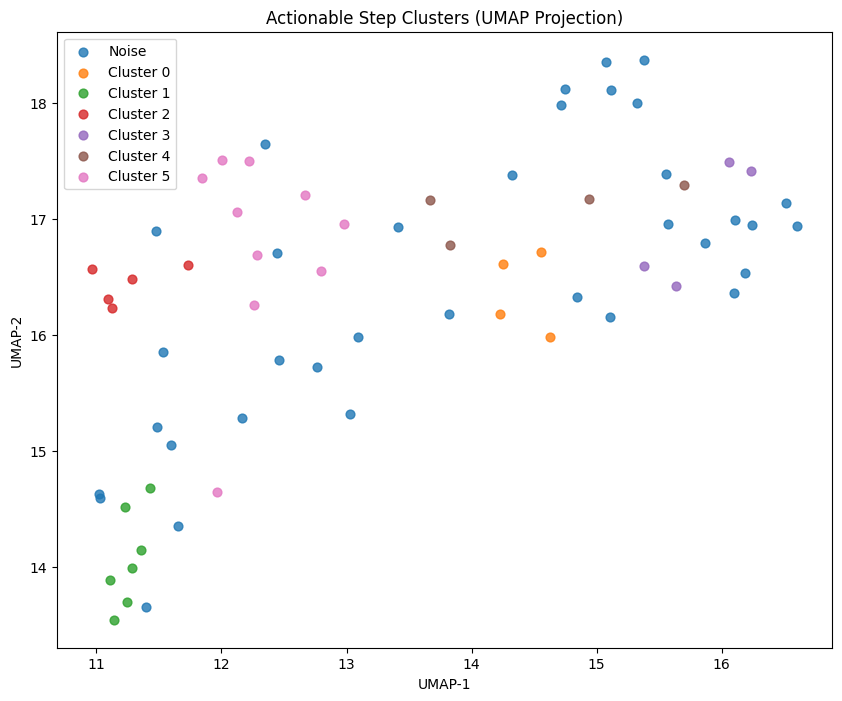

In [9]:
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Extract embeddings + cluster labels
X = np.array([s["embedding"] for s in all_steps])
labels = np.array([s["cluster"] for s in all_steps])
steps_text = [s["step"] for s in all_steps]

# Project to 2D using UMAP (recommended for embeddings)
reducer = umap.UMAP(
    n_neighbors=12,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

embedding_2d = reducer.fit_transform(X)

# Plot
plt.figure(figsize=(10, 8))
unique_labels = sorted(set(labels))

for lab in unique_labels:
    mask = labels == lab
    label_name = f"Cluster {lab}" if lab != -1 else "Noise"
    plt.scatter(
        embedding_2d[mask, 0],
        embedding_2d[mask, 1],
        s=40,
        alpha=0.8,
        label=label_name
    )

plt.legend()
plt.title("Actionable Step Clusters (UMAP Projection)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

In [35]:
from scipy.spatial.distance import cosine

final_steps = []

for cid, items in clusters.items():
    combined_text = "\n".join([i["step"] for i in items])

    # Summarize cluster
    summary_resp = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "Summarize similar steps into one clean actionable step."},
            {"role": "user", "content": f"Combine these into one step:\n{combined_text}"}
        ],
        temperature=0.2,
        max_tokens=80
    )

    summary = summary_resp.choices[0].message.content.strip()

    # Compute cluster relevance to query
    q = np.array(q_emb)
    rel_scores = []
    for i in items:
        emb = np.array(i["embedding"])
        rel = 1 - cosine(emb, q)
        rel_scores.append(float(rel))

    final_steps.append({
        "cluster_id": cid,
        "action_step": summary,
        "frequency": len(items),
        "avg_relevance": float(np.mean(rel_scores)),
        "sources": [
            {
                "submission_id": i["submission_id"],
                "url": i["permalink"],
                "score": i["score"],
                "relevance": float(1 - cosine(np.array(i["embedding"]), q)),
                "original_step": i["step"],
                "step_embedding": i["embedding"]
            }
            for i in items
        ]
    })

# Sort higher frequency + higher relevance first
final_steps.sort(
    key=lambda x: (x["frequency"], x["avg_relevance"]),
    reverse=True
)

In [36]:
print(json.dumps(final_steps, indent=5))

[
     {
          "cluster_id": 5,
          "action_step": "Prioritize self-love and personal growth by maintaining a positive mindset, focusing on mental well-being, and ignoring negativity from others, including judgmental opinions and negative self-talk.",
          "frequency": 10,
          "avg_relevance": 0.30770504616827055,
          "sources": [
               {
                    "submission_id": "9hjn8y",
                    "url": "https://www.reddit.com/r/loseit/comments/9hjn8y/everything_ive_learned_about_obesity_is_right_and/",
                    "score": 376,
                    "relevance": 0.17797739984227978,
                    "original_step": "Ignore negative comments from others",
                    "step_embedding": [
                         0.003919364418834448,
                         0.004757249727845192,
                         0.009099018760025501,
                         0.018558120355010033,
                         -0.02343308925628662,
       

In [37]:
for cluster in final_steps:
    # Advice based scoring
    src_scores = [s["score"] for s in cluster["sources"]]
    cluster_value = np.mean(src_scores)/ np.max(src_scores)
    cluster['cluster_value'] = cluster_value

print(len(final_steps))

print(json.dumps(final_steps, indent=5))

filtered_clusters = [cluster for cluster in final_steps if cluster['cluster_value'] > 0.20]
print(len(filtered_clusters))

6
[
     {
          "cluster_id": 5,
          "action_step": "Prioritize self-love and personal growth by maintaining a positive mindset, focusing on mental well-being, and ignoring negativity from others, including judgmental opinions and negative self-talk.",
          "frequency": 10,
          "avg_relevance": 0.30770504616827055,
          "sources": [
               {
                    "submission_id": "9hjn8y",
                    "url": "https://www.reddit.com/r/loseit/comments/9hjn8y/everything_ive_learned_about_obesity_is_right_and/",
                    "score": 376,
                    "relevance": 0.17797739984227978,
                    "original_step": "Ignore negative comments from others",
                    "step_embedding": [
                         0.003919364418834448,
                         0.004757249727845192,
                         0.009099018760025501,
                         0.018558120355010033,
                         -0.02343308925628662,
     

In [ ]:
# import json

# # How many clusters you filtered out earlier

# # Convert final_steps list to JSON (LLM-friendly)
# final_steps_json = json.dumps(final_steps, indent=2)

# final_prompt = f"""
# You are producing distilled, high-confidence actionable steps based on crowdsourced insights.

# Here is the processed dataset of clusters, each containing:
# - action_step (summary of similar steps)
# - frequency (how many people said it)
# - avg_relevance (semantic relevance to the user’s question)
# - usefulness (normalized Reddit score)
# - cluster_id
# - sources

# Your job:
# 1. Present the final actionable steps in a ranked list (most supported + most relevant first).
# 2. For each step, show:
#    - The actionable step
#    - How many people independently mentioned it (frequency)
#    - Why it’s relevant
# 3. Write in a clean, motivational, practical tone. No fluff. Just clarity.

# Here is the input data:
# {final_steps_json}
# """

# # Call OpenAI
# resp = client.chat.completions.create(
#     model="gpt-4o",
#     messages=[
#         {"role": "system", "content": "You are a concise, structured advisor."},
#         {"role": "user", "content": final_prompt}
#     ],
#     temperature=0.3,
#     max_tokens=800
# )

# final_output = resp.choices[0].message.content

# print(final_output)


Here are the distilled, actionable steps ranked by support and relevance:

1. **Join and Engage with Supportive Communities**
   - **Frequency:** 7 mentions
   - **Relevance:** Engaging with communities that resonate with your journey provides encouragement, motivation, and inspiration. Reading success stories and sharing your experiences can boost your morale and help you stay committed.

2. **Acknowledge and Accept Your Current Situation**
   - **Frequency:** 5 mentions
   - **Relevance:** Accepting your current state without self-judgment empowers you to recognize your personal responsibility and the power to change. This mindset is crucial for committing to positive changes despite challenges.

3. **Prioritize Self-Love and Personal Growth**
   - **Frequency:** 10 mentions
   - **Relevance:** Maintaining a positive mindset and focusing on mental well-being helps you ignore negativity from others and negative self-talk. This is essential for personal growth and achieving your goals.

Selecting the best representative from each cluster


In [46]:
from scipy.spatial.distance import cosine
import numpy as np

action_steps = []

for cluster in filtered_clusters:
    
    # Extract step embeddings safely
    step_embeds = np.array(
        [np.array(source['step_embedding'], dtype=float) for source in cluster['sources']]
    )
    
    # Compute centroid of the cluster
    centroid = np.mean(step_embeds, axis=0)

    # Compute cosine DISTANCES to centroid
    distances = [cosine(e, centroid) for e in step_embeds]

    # Best representative = minimum distance to centroid
    best_index = int(np.argmin(distances))

    best_source = cluster['sources'][best_index]
    # Usefullness scores
    """
    A usefull score must tie : 
        --> How relevant it is to the query,
        --> How it represents the clusters, idea
        --> Crowd source or cluster relevance 
    """

    relevance = best_source["relevance"]
    centroid_sim = 1 - cosine(best_source["step_embedding"], centroid)
    cluster_value = cluster["cluster_value"]  

    usefulness = 0.5 * relevance + 0.3 * centroid_sim + 0.2 * cluster_value
 
    action_steps.append({
        "url": best_source['url'],
        "step": best_source['original_step'],
        "usefulness": usefulness
    })


In [53]:
ranked_action_steps = sorted(action_steps, key=lambda x : x['usefulness'], reverse=True)
print("Next Recommended Steps")
for step in ranked_action_steps:
    print(f"{step['step']}, {int(step['usefulness'] * 100)} % found this usefull")

Next Recommended Steps
Accept your body type and set realistic expectations for weight loss., 56 % found this usefull
Join supportive communities for encouragement., 55 % found this usefull
Acknowledge your feelings and commit to change., 52 % found this usefull
Focus on improving your diet., 51 % found this usefull
Enjoy food while maintaining your goals., 49 % found this usefull
